# DATA PROJECT: A dive into the Danish private sector

**TABLE OF CONTENTS**<a id='toc0_'></a>    
- [1. Project description](#toc1_)    
- [2. Imports and set magics](#toc2_) 
- [3. Read, clean and explore data](#toc3_)
    - 3.1. [Dataset GF02 - active firms given time, industry, size and region](#toc3_1_)
    - 3.2. [Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc3_2_)  
- [4. Merging the datasets](#toc4_)
- [5. Analysis](#toc5_)
- [6. Concluding remarks](#toc6_)
   

## 1. <a id='toc1_'></a>[Project description](#toc0_)

The idea behind the project is to...

## 2. <a id='toc2_'></a>[Imports and set magics](#toc0_)

In [49]:
# As we will use data from Statistics Denmark (Statistikbanken) we will be using the DstApi to access that data.
# If you previously have not installed it through github, the hashtag below should be deleted and the "%pip..." line should be run.
# More info the DstApi can be found by following the link below to the githhub page explaining the Api.

#%pip install git+https://github.com/alemartinello/dstapi


In [50]:
# We import different packages for the further analysis - among these the DstApi that has been installed via the code above.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import datetime
import ipywidgets as widgets
from matplotlib_venn import venn2
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. <a id='toc3_'></a>[Read, clean and explore data](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Dataset GF02 - active firms given time, industry, size and region](#toc0_)

#### Importing the dataset

In [51]:
gf02_api = DstApi('GF02') 

In [52]:
tabsum = gf02_api.tablesummary(language='en')
display(tabsum)

Table GF02: General enterprise statistics by Municipality, Industry (DB07 10- 19- and 127 grouping and detailed), enterprise size (full time equivalents) and time
Last update: 2023-05-05T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,KOMK,118,000,All Denmark,12,Outside from Denmark,False
1,BRANCHEDB0710TIL127,902,TOT,TOT Industry total,999999,999999 Activity not stated,False
2,FIRMSTR,6,TOT,"Total, all enterprises",103,250 employees and more,False
3,Tid,15,2007,2007,2021,2021,True


In [53]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(gf02_api.variable_levels(variable, language='en'))

KOMK:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
113,820,Vesthimmerlands
114,851,Aalborg
115,099,Region unknown
116,098,Municipality unknown


BRANCHEDB0710TIL127:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,A,"A Agriculture, forestry and fishing"
3,01000,01000 Agriculture and horticulture
4,011100,"011100 Growing of cereals (except rice), legum..."
...,...,...
897,990000,990000 Activities of extraterritorial organiza...
898,11,11 Activity not stated
899,X,X Activity not stated
900,99999,99999 Activity not stated


FIRMSTR:


,id,text
0,TOT,"Total, all enterprises"
1,0000,No employed
2,010,Less than 10 employed
3,101,10-49 employees
4,102,50-249 employees
5,103,250 employees and more


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


In [54]:
params = gf02_api._define_base_params(language='en')
params

{'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['*']},
  {'code': 'BRANCHEDB0710TIL127', 'values': ['*']},
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [55]:
params_gf02 = {'table': 'gf02',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'KOMK', 'values': ['000']}, #we look at companies in all of Denmark
  {'code': 'BRANCHEDB0710TIL127', 'values': ['TOT']}, #we look at all industries in Denmark
  {'code': 'FIRMSTR', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [56]:
gf02_all = gf02_api.get_data(params=params_gf02)
gf02_all.head(5)

,KOMK,BRANCHEDB0710TIL127,FIRMSTR,TID,INDHOLD
0,All Denmark,TOT Industry total,No employed,2007,168183
1,All Denmark,TOT Industry total,Less than 10 employed,2007,111481
2,All Denmark,TOT Industry total,10-49 employees,2007,21004
3,All Denmark,TOT Industry total,50-249 employees,2007,3816
4,All Denmark,TOT Industry total,250 employees and more,2007,835


In [57]:
gf02_size = gf02_api.get_data(params=params_gf02)
gf02_size

,KOMK,BRANCHEDB0710TIL127,FIRMSTR,TID,INDHOLD
0,All Denmark,TOT Industry total,No employed,2007,168183
1,All Denmark,TOT Industry total,Less than 10 employed,2007,111481
2,All Denmark,TOT Industry total,10-49 employees,2007,21004
3,All Denmark,TOT Industry total,50-249 employees,2007,3816
4,All Denmark,TOT Industry total,250 employees and more,2007,835
...,...,...,...,...,...
85,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
86,All Denmark,TOT Industry total,10-49 employees,2021,19594
87,All Denmark,TOT Industry total,50-249 employees,2021,3945
88,All Denmark,TOT Industry total,250 employees and more,2021,870


#### Cleaning and renaming the dataset

In [58]:
gf02_size.drop(['KOMK', 'BRANCHEDB0710TIL127'] , axis=1, inplace=True,)
gf02_size.rename(columns = {'FIRMSTR':'size', 'TID':'year', 'INDHOLD':'#companies'}, inplace=True)
gf02_size

,size,year,#companies
0,No employed,2007,168183
1,Less than 10 employed,2007,111481
2,10-49 employees,2007,21004
3,50-249 employees,2007,3816
4,250 employees and more,2007,835
...,...,...,...
85,Less than 10 employed,2021,154138
86,10-49 employees,2021,19594
87,50-249 employees,2021,3945
88,250 employees and more,2021,870


In [59]:
gf02_size_wide = gf02_size.pivot(index='size', columns='year', values='#companies')
gf02_size_wide = gf02_size_wide.reindex(['No employed', 'Less than 10 employed', '10-49 employees', '50-249 employees', '250 employees and more','Total, all enterprises'])
gf02_size_wide

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
size,,,,,,,,,,,,,,,
No employed,168183,168010,156529,158551,160589,161036,153368,139273,134794,142595,144520,145036,147459,147315,149898
Less than 10 employed,111481,117855,116338,117684,118175,118479,123337,138907,140447,143122,145775,147930,150226,151612,154138
10-49 employees,21004,20998,19053,17917,17938,17911,17855,17449,17771,18110,18596,19349,19141,19093,19594
50-249 employees,3816,3814,3379,3170,3261,3293,3270,3384,3436,3512,3628,3798,3813,3825,3945
250 employees and more,835,841,773,759,770,764,751,750,790,818,812,857,855,850,870
"Total, all enterprises",305319,311518,296072,298081,300733,301483,298581,299763,297238,308157,313331,316970,321494,322695,328445


In [60]:
gf02_size_wide.describe()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,101773.000000,103839.333333,98690.666667,99360.333333,100244.333333,100494.333333,99527.00000,99921.000000,99079.333333,102719.00000,104443.666667,105656.666667,107164.666667,107565.000000,109481.666667
std,120202.489603,122410.091453,116301.705168,117419.772481,118519.142342,118827.127626,117286.56198,117440.387821,116338.440563,120674.59978,122655.169063,123934.065441,125814.508684,126315.866951,128519.947259
min,835.000000,841.000000,773.000000,759.000000,770.000000,764.000000,751.00000,750.000000,790.000000,818.00000,812.000000,857.000000,855.000000,850.000000,870.000000
25%,8113.000000,8110.000000,7297.500000,6856.750000,6930.250000,6947.500000,6916.25000,6900.250000,7019.750000,7161.50000,7370.000000,7685.750000,7645.000000,7642.000000,7857.250000
50%,66242.500000,69426.500000,67695.500000,67800.500000,68056.500000,68195.000000,70596.00000,78178.000000,76282.500000,80352.50000,81558.000000,82192.500000,83300.000000,83204.000000,84746.000000
75%,154007.500000,155471.250000,146481.250000,148334.250000,149985.500000,150396.750000,145860.25000,139181.500000,139033.750000,142990.25000,145461.250000,147206.500000,149534.250000,150537.750000,153078.000000
max,305319.000000,311518.000000,296072.000000,298081.000000,300733.000000,301483.000000,298581.00000,299763.000000,297238.000000,308157.00000,313331.000000,316970.000000,321494.000000,322695.000000,328445.000000


In [61]:
#Call function from py-file
#var_keep = ['region', 'All Denmark']
#gf02_filtered = dataproject.keep_regs(gf02_all, var_keep)

In [62]:
#I = gf02_all.regions.str.contains('Region')
#I |= gf02_all.regions.str.contains('All Denmark')
#gf02_all.loc[I, :]

In [63]:
#gf02_reduce = gf02_all.loc[I == True] # drop everything else
#gf02_reduce.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
#gf02_reduce.iloc[0:153,:]
#gf02_reduce

#### Exploring the dataset

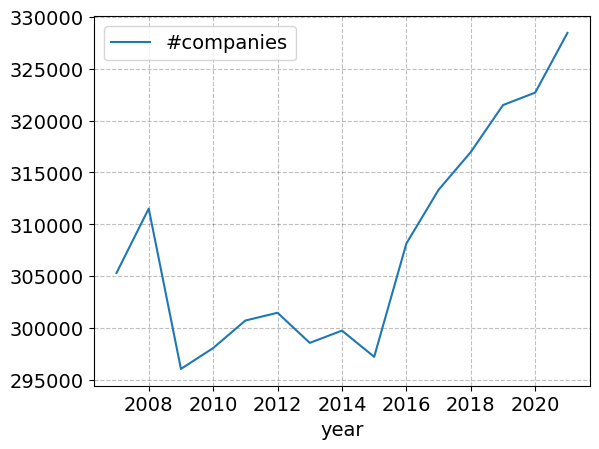

In [64]:
gf02_size_plot1 = gf02_size.loc[gf02_size['size'] == 'Total, all enterprises', :]

# Plot the content of the data frame
gf02_size_plot1.plot(x='year',y='#companies',legend="total companies in Denmark");

In [65]:
def plot_gf02_size(df, size): 
    I = df['size'] == size
    ax=df.loc[I,:].plot(x='year', y='#companies', style='-o', legend=False)

In [66]:
widgets.interact(plot_gf02_size, 
    df = widgets.fixed(gf02_size),
    size = widgets.Dropdown(description='Size', 
                            options=gf02_size['size'].unique(), 
                            value='Total, all enterprises')
);

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

### 3.2. <a id='toc3_2_'></a>[Dataset DEMO4 - start-ups and bankruptcies over time and for different industries](#toc0_)

#### Importing the dataset

As we are using another dataset from Statistics Denmark, we apply the same approach as described with the previous dataset (GF02).

In [ ]:
demo4_api = DstApi('DEMO4')

In [ ]:
tabsum2 = demo4_api.tablesummary(language='en')
display(tabsum2)

In [ ]:
# The available values for a each variable: 
for variable in tabsum2['variable name']:
    print(variable+':')
    display(demo4_api.variable_levels(variable, language='en'))

In [ ]:
params_demo4 = demo4_api._define_base_params(language='en')
params_demo4

In [ ]:
params_demo4 = {'table': 'demo4',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'REGION', 'values': ['*']},
  {'code': 'BRANCHEDB0710', 'values': ['*']},
  {'code': 'MÆNGDE4', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [ ]:
demo4_all = demo4_api.get_data(params=params_demo4)
demo4_all.head(5)

#### Cleaning and renaming the dataset

In [ ]:
demo4_all.rename(columns = {'REGION':'regions','BRANCHEDB0710':'Industry', 'MÆNGDE4': 'X', 'TID':'Time', 'INDHOLD':'Total'}, inplace=True)
demo4_all.head()

In [ ]:
I = demo4_all.regions.str.contains('regions')
I |= demo4_all.regions.str.contains('All Denmark')
demo4_all.loc[I, :]

In [ ]:
demo4_reduce = demo4_all.loc[I == True] # drop everything else
demo4_reduce.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
demo4_reduce.iloc[0:214,:]
demo4_reduce

In [ ]:
demo4_reduce.describe()

In [ ]:
I = demo4_all.regions.str.contains('Region')
demo4_all.loc[I, :]

In [ ]:
demo4_reduced = demo4_all.loc[I == False] # keep everything else
demo4_reduced.head(10)

In [ ]:
demo4_reduced.reset_index(inplace = True, drop = True) # Drop old index too. If the drop is not used, python will create another dataset with the old index.
demo4_reduced.iloc[0:214,:]
demo4_reduced

#### Exploring the dataset

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


Explain what you see when moving elements of the interactive plot around. 

## 4. <a id='toc4_'></a>[Merging the datasets](#toc0_)

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

## 5. <a id='toc5_'></a>[Analysis](#toc0_)

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

## 6. <a id='toc6_'></a>[Concluding remarks](#toc0_)

ADD CONCISE CONLUSION.